In [1]:
import os
import getpass
import numpy as np
import pandas as pd
from time import time
from functools import reduce
import matplotlib.pyplot as plt

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Own lasso Liberay
import lasso_model 

# Lasso to Forecast Inflation

**How to read this notebook:**

---

1. **Data**  
We load and prepare the dataset for modeling, including setting the target (inflation) and explanatory variables.  
Features are standardized to ensure comparability, which is essential for LASSO's variable selection.

---

2. **Forecast**  
We apply the LASSO model to forecast inflation *h* months ahead from a given point in time (*last_observation_date*), using a fixed training window of *window_length* months.  
The regularization parameter (α) is chosen via cross-validation.

    2.1. **Variable Selection**  
    After fitting, we examine the non-zero coefficients to identify which explanatory variables drive the forecast at horizon *h*.

---

3. **Rolling Forecasts**  
We implement a multi-horizon rolling window approach that mimics real-world forecasting. At each time point (e.g., January 2023), the model is trained on the most recent 96 months of data and used to forecast inflation 1 to 12 months ahead.  
The window then rolls forward by one month, and the process repeats.  
This procedure follows the real-time setup from Garcia et al. (2017).

---

4. **Model Evaluation**

     4.1. **Forecast Accuracy by Horizon** \
      We report standard metrics:
        - Mean Absolute Error (MAE)
        - Root Mean Squared Error (RMSE)  
    for each forecast horizon using the rolling forecasts.

    4.2. **Forecast Details (Example: 1-month ahead)**  
    We present detailed forecast vs. actual values, forecast errors, and squared errors for a selected horizon (e.g. *h* = 1).


# 1. Data processing

In [5]:
# Gå et niveau op og naviger til mappen "Data"
os.chdir('../Data')

In [6]:
# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 268)


In [7]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 267)


# 2. Forecast

We now use the prepared dataset to generate inflation forecasts using the LASSO model.

The approach follows a **direct multi-horizon setup**, where a separate LASSO model is estimated for each forecast horizon \( h = 1, \dots, 12 \). Each model is trained on a fixed-length rolling window (here: 9 years or 108 months) ending at the specified `last_observation_date`.

The regularization parameter (α) is selected via time-series cross-validation for each model individually.

By setting `return_models=True`, we also retain access to the fitted models in order to analyze which variables drive the forecasts at each horizon.

In [10]:
forecast_horizon = 12 # 1 year
window_length = 9*12 # 12 Years
last_observation_date = "2023-12-01"

In [11]:
%%time
forecast_df, lasso_models = lasso_model.lasso_forecast(
    X=X,
    y=y, 
    forecast_horizon=forecast_horizon,
    last_observation_date=last_observation_date,
    scaler=scaler, 
    window_length=window_length,
    verbose=True, 
    return_models = True
)


=== Horizon h=1 ===
Number of training observations: 108
Selected alpha: 0.00072
Zero coefficients: 166, Non-zero coefficients: 101

=== Horizon h=2 ===
Number of training observations: 107
Selected alpha: 0.01177
Zero coefficients: 206, Non-zero coefficients: 61

=== Horizon h=3 ===
Number of training observations: 106
Selected alpha: 0.01048
Zero coefficients: 203, Non-zero coefficients: 64

=== Horizon h=4 ===
Number of training observations: 105
Selected alpha: 0.00036
Zero coefficients: 160, Non-zero coefficients: 107

=== Horizon h=5 ===
Number of training observations: 104
Selected alpha: 0.00830
Zero coefficients: 200, Non-zero coefficients: 67

=== Horizon h=6 ===
Number of training observations: 103
Selected alpha: 0.00830
Zero coefficients: 201, Non-zero coefficients: 66

=== Horizon h=7 ===
Number of training observations: 102
Selected alpha: 0.00521
Zero coefficients: 193, Non-zero coefficients: 74

=== Horizon h=8 ===
Number of training observations: 101
Selected alpha: 

In [13]:
df_inflation = pd.merge(
    forecast_df.set_index("Date"),
    y,
    left_index=True,
    right_index=True,
    how="left"
)

In [14]:
df_inflation

,Horizon,Inflation forecast,Inflation
Date,,,
2024-01-01,0,0.658533,1.203
2024-02-01,1,-0.349252,0.766
2024-03-01,2,0.385687,0.938
2024-04-01,3,1.337120,0.765
2024-05-01,4,2.201330,2.155
2024-06-01,5,2.582075,1.804
2024-07-01,6,2.277390,1.097
2024-08-01,7,2.624867,1.359
2024-09-01,8,2.943320,1.278


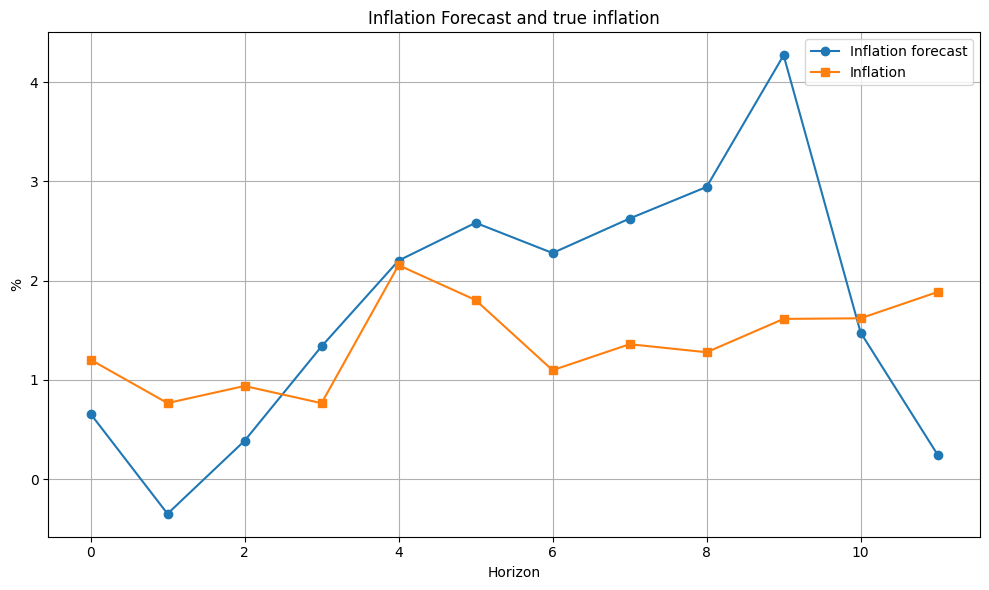

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(df_inflation['Horizon'], df_inflation['Inflation forecast'], marker='o', label='Inflation forecast')
plt.plot(df_inflation['Horizon'], df_inflation['Inflation'], marker='s', label='Inflation')
plt.xlabel('Horizon')
plt.ylabel('%')
plt.title('Inflation Forecast and true inflation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 2.1. Variable Selection  

After estimating a separate LASSO model for each forecast horizon, we analyze which explanatory variables are selected (i.e., have non-zero coefficients).

The table below summarizes the top 15 variables based on two criteria:
- **Frequency**: Number of horizons in which the variable is selected
- **Total Absolute Weight**: Sum of the absolute LASSO coefficients across all horizons

This helps identify which macroeconomic indicators consistently drive inflation forecasts across time horizons — both in terms of presence and magnitude.


In [25]:
from collections import defaultdict, Counter

# To målinger: hvor ofte valgt, og samlet vægt
feature_freq = Counter()
feature_weight = defaultdict(float)

for h, model in lasso_models.items():
    coefs = model.coef_
    features = X.columns

    for f, c in zip(features, coefs):
        if c != 0:
            feature_freq[f] += 1
            feature_weight[f] += abs(c)  # Brug absolut værdi af vægten

# Kombinér i én DataFrame
summary_df = pd.DataFrame({
    "Frequency": pd.Series(feature_freq),
    "Total_Abs_Weight": pd.Series(feature_weight)
})

# Sortér efter samlet vægt eller frekvens
summary_df = summary_df.sort_values("Total_Abs_Weight", ascending=False)

# Vis top 15
summary_df.head(15)

,Frequency,Total_Abs_Weight
"Electricity Import, Net",8,5.183267
inflation_rolling_mean3,3,4.857168
"Priser om et år, sammenlignet med i dag",11,3.983972
P.62 Eksport af tjenester,8,3.934066
"Danmarks økonomiske situation i dag, sammenlignet med for et år siden",7,3.026884
05.5 Værktøj og udstyr til hus og have,11,3.022272
P.53 Anskaffelser minus afhændelser af værdigenstande,11,2.329176
"Anskaffelse af større forbrugsgoder, inden for de næste 12 mdr.",10,2.232858
EUR Euro (Jan. 1999-),12,2.130541
Ledige kontanthjælpsmodtagere,5,2.016292


As shown above, variables such as *Electricity Import, Net* and *Prices compared to one year ago* appear frequently and carry substantial weight across multiple horizons. 

This suggests that energy-related and consumer-expectation variables are particularly influential in explaining future inflation dynamics in this model.

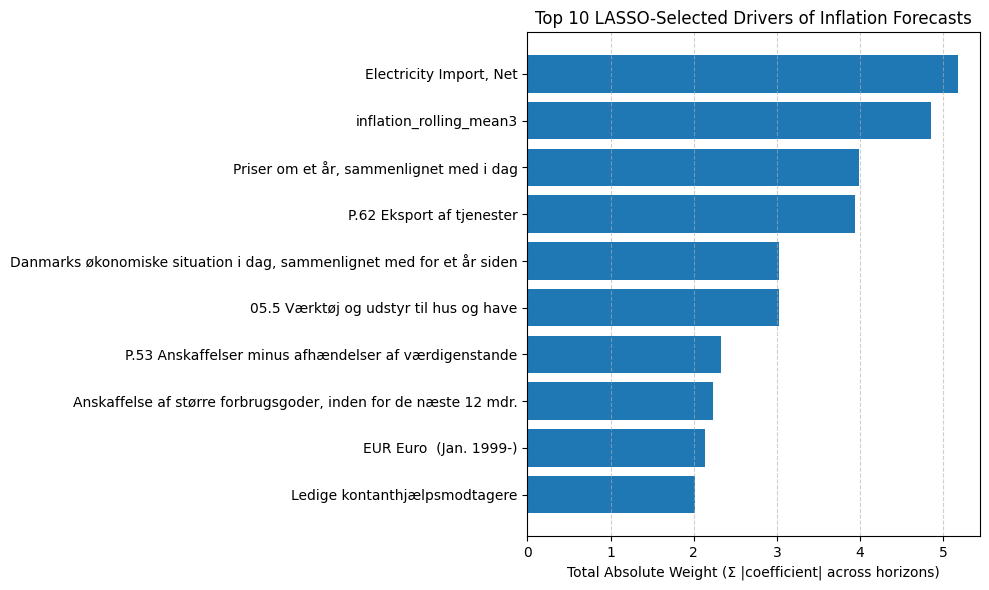

In [28]:
# Top 10 most importent variabler
top_features = summary_df.sort_values("Total_Abs_Weight", ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(top_features.index[::-1], top_features["Total_Abs_Weight"][::-1])
plt.xlabel("Total Absolute Weight (Σ |coefficient| across horizons)")
plt.title("Top 10 LASSO-Selected Drivers of Inflation Forecasts")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# 3. Rolling Forecasts  

In [78]:
forecast_results = lasso_model.run_rolling_forecast(
    X=X, 
    y=y,
    forecast_horizon=12, 
    start_date="2023-01-01", 
    end_date="2024-12-01", 
    window_length=108
)

# 4. Model Evaluation
## 4.1 Forecast Accuracy by Horizon

To assess how forecast performance varies across time horizons, we compute standard accuracy metrics:

- **MAE** (Mean Absolute Error): Average absolute deviation from actual inflation
- **RMSE** (Root Mean Squared Error): Penalizes large errors more heavily
- **N_obs**: Number of evaluation points for each horizon

The table below reports these metrics for each horizon \( h = 1, .. , 12 \), where horizon 0 corresponds to 1-month-ahead forecasts and horizon 11 to 12-months-ahead forecasts.

This gives a sense of how quickly forecast quality deteriorates as the prediction horizon increases.

In [32]:
eval_df, merged_df = lasso_model.evaluate_forecasts(forecast_results, y)
eval_df

,Horizon,MAE,RMSE,N_obs
0,0,0.602574,0.841115,23
1,1,1.102792,1.514320,22
2,2,1.247927,1.635411,21
3,3,1.533765,2.060913,20
4,4,1.940887,2.386501,19
5,5,1.581883,2.215927,18
6,6,1.651834,2.310649,17
7,7,1.315679,2.277070,16
8,8,2.012247,3.296624,15
9,9,2.125651,3.389390,14


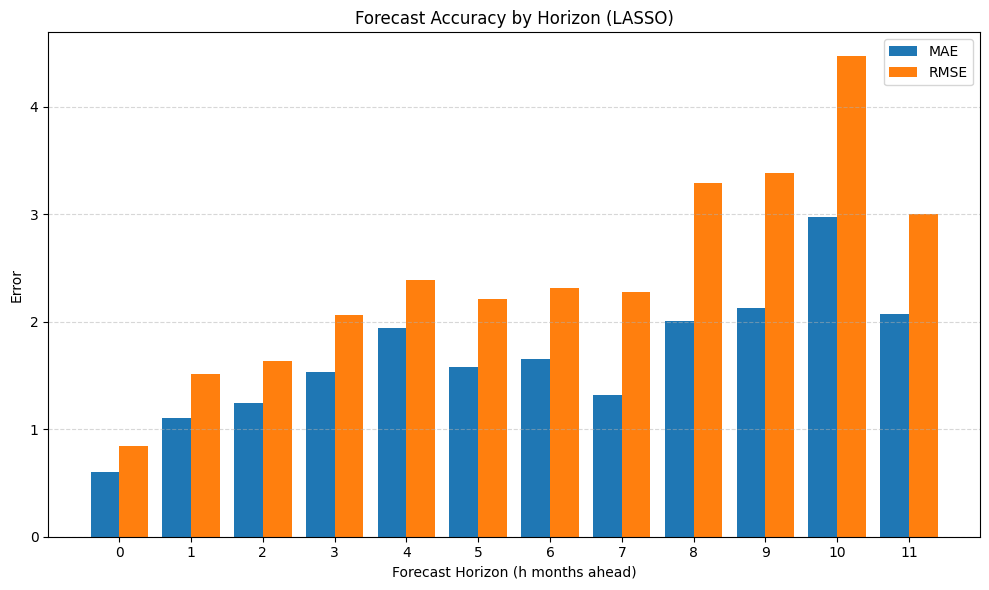

In [122]:
plt.figure(figsize=(10, 6))
h = eval_df["Horizon"]

# Plot MAE og RMSE som søjler
bar_width = 0.4
plt.bar(h - bar_width/2, eval_df["MAE"], width=bar_width, label="MAE")
plt.bar(h + bar_width/2, eval_df["RMSE"], width=bar_width, label="RMSE")

plt.xlabel("Forecast Horizon (h months ahead)")
plt.ylabel("Error")
plt.title("Forecast Accuracy by Horizon (LASSO)")
plt.xticks(h)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


The chart below visualizes forecast errors (MAE and RMSE) for each horizon.  
As expected, accuracy decreases with longer horizons, with noticeable jumps in RMSE beyond 6 months.

This helps assess at which point the model’s forecasts become less reliable and potentially guides the choice of usable forecast range.

## 4.2. Forecast Details (Example: 1-month ahead)

In this section, we inspect the LASSO model's 1-month-ahead forecast in detail.  
We begin by isolating forecasts where the horizon is exactly 1 month (\( h = 0 \) in zero-indexed format), and merge these with actual inflation data to compute forecast errors.

We calculate and visualize:
- Raw forecast error and squared error per month
- 12-month averages to evaluate performance over time
- Numerical comparison between forecasted and actual cumulative inflation


In [93]:
h1 = merged_df[merged_df["Horizon"] == 0]
h1

,Date,Horizon,Inflation forecast,Forecast_made_in,y_true,error,abs_error,squared_error
0,2023-02-01,0,7.705513,2023-01-01,7.601,0.104513,0.104513,0.010923
12,2023-03-01,0,7.609293,2023-02-01,6.733,0.876293,0.876293,0.767890
24,2023-04-01,0,6.747416,2023-03-01,5.282,1.465416,1.465416,2.147443
36,2023-05-01,0,5.290144,2023-04-01,2.928,2.362144,2.362144,5.579726
48,2023-06-01,0,2.994897,2023-05-01,2.465,0.529897,0.529897,0.280791
60,2023-07-01,0,2.464130,2023-06-01,3.133,-0.668870,0.668870,0.447387
72,2023-08-01,0,3.133362,2023-07-01,2.437,0.696362,0.696362,0.484920
84,2023-09-01,0,2.478070,2023-08-01,0.859,1.619070,1.619070,2.621387
96,2023-10-01,0,0.920298,2023-09-01,0.085,0.835298,0.835298,0.697722
108,2023-11-01,0,0.262586,2023-10-01,0.600,-0.337414,0.337414,0.113848


The chart above shows the model's forecast errors over time.  
We observe that the largest forecast deviations occur in early 2023, possibly due to post-pandemic volatility or energy price shocks.

The numerical comparison of 12-month accumulated inflation shows that the LASSO model performs reasonably well in tracking the true inflation path — though with some periods of under- or over-estimation.

#### Annualized Inflation Comparison

To evaluate the forecast model over longer horizons, we compute the average annualized inflation for two distinct 12-month periods. 
For each period, we calculate the average of the forecasted monthly inflation and compare it to the average of the actual inflation.

This gives a sense of how well the LASSO model tracks long-run inflation dynamics over time.


In [110]:
# Definér perioder og årstal
periods = {
    "2023": slice(0, 12),
    "2024": slice(12, 24)
}

# Beregn og print gennemsnitlig inflation per år
for year, s in periods.items():
    forecast_avg = h1["Inflation forecast"].iloc[s].mean()
    actual_avg = h1["y_true"].iloc[s].mean()

    print(f"\n=== {year} ===")
    print(f"Forecasted avg. inflation: {forecast_avg:.3f}")
    print(f"Actual avg. inflation:     {actual_avg:.3f}")
    print(f"Forecast error (pp):       {forecast_avg - actual_avg:.3f}")



=== 2023 ===
Forecasted avg. inflation: 3.392
Actual avg. inflation:     2.835
Forecast error (pp):       0.557

=== 2024 ===
Forecasted avg. inflation: 1.313
Actual avg. inflation:     1.389
Forecast error (pp):       -0.076


#### Forecast Error Over Time (h = 1)
The chart below shows the monthly forecast error and squared error for the 1-month-ahead horizon.  
It helps visualize the timing and severity of forecast deviations throughout the period.

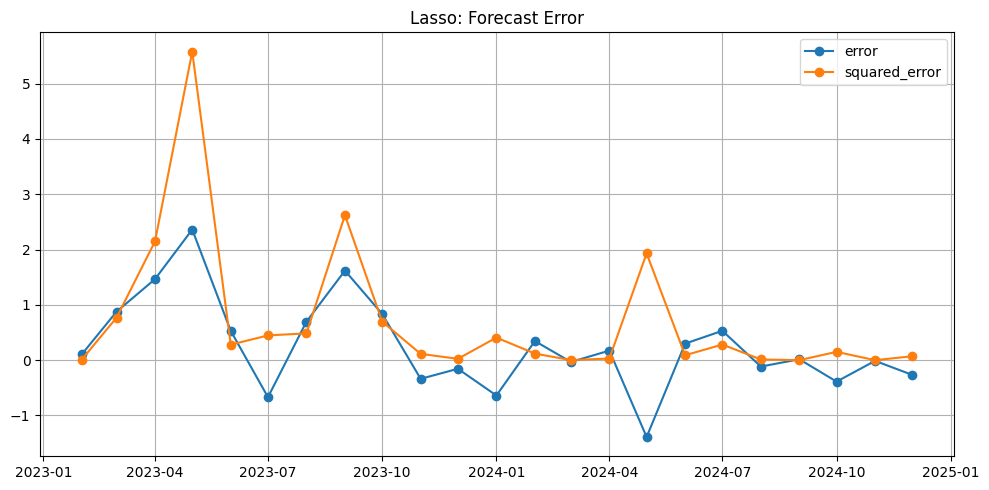

In [112]:
plt.figure(figsize=(10, 5))
plt.plot(h1["Date"], h1["error"], label="error", marker="o")
#plt.plot(h1["Date"], h1["abs_error"], label="abs_error", marker="o")
plt.plot(h1["Date"], h1["squared_error"], label="squared_error", marker="o")
plt.legend()
plt.title("Lasso: Forecast Error")
plt.grid(True)
plt.tight_layout()
plt.show()

Large squared errors in early 2023 reflect a period of heightened macroeconomic uncertainty.  
In particular, the aftermath of the European energy crisis — with volatile electricity and gas prices — made it difficult for the model to capture sudden inflation swings.  
This suggests that purely data-driven models like LASSO may struggle when structural shocks dominate.
